# GROUP 7 DSFT09 HYBRID PHASE 4
1.Mirriam Mumbua<br>
2.Martin Kandie<br>
3.Gilead Gad <br>
4.Roobinson Karasha<br>
5.Graffin Kiprotich<br>

 # Multi-Label Emotion Classification Using NLP: Analyzing Emotional Tone in Social Media and Text Data

![Local Image](./emotionimage.png)

## Project overview
### Problem Statement
##### This project aims to build an emotion classifier using the GoEmotions dataset, which includes human-labeled Reddit comments annotated for 27 emotion categories. The goal is to develop a model that can accurately classify text into one of these emotions, which can be applied to analyzing social media comments, reviews, or even customer feedback to detect emotional tone.

### Business Understanding

Companies can categorise consumer emotions from text data (such as social media postings, customer reviews, or support tickets) by using the GoEmotions dataset. Through comprehending the feelings conveyed in client feedback, businesses can:
* Enhance consumer Experience: 
Recognise and address consumer annoyance or discontent (such as rage or grief) as soon as possible.
* Improved Client Assistance :
Assign complaints and enquiries to the appropriate support staff automatically based on the emotional tone of the communication (e.g., furious clients can be prioritised for resolution).
* Customise Marketing:
 Create more effective and individualised outreach by incorporating client emotions into communication methods or adverts.Companies can categorise consumer emotions from text data (such as social media postings, customer reviews, or support tickets) by using the GoEmotions dataset. By comprehending the feelings conveyed in customer feedback

### Data Understanding.
##### The GoEmotions dataset was sourced from Reddit, a popular social media platform where users post comments on various topics. Specifically, the dataset consists of over 58,000 Reddit comments that were manually annotated by human labelers into 27 distinct emotion categories (such as joy, anger, sadness, curiosity, and more).The dataset was created by Google Research as part of their efforts to advance Natural Language Processing (NLP) research. The comments were collected from publicly available Reddit posts, ensuring a wide variety of topics and emotional expressions. The comments were then labeled with one or more emotions, making it a multi-label classification problem.

## Objective
### Develop a machine learning model capable of:
* ##### Multi-label emotion detection: Predicting one or more emotion categories for each Reddit comment from the 27 possible emotion classes.also using the six basic ekman emotions
* ##### Handling noisy and real-world text: Effectively preprocessing the text (e.g., dealing with slang, abbreviations, and varied sentence structures in Reddit comments) to ensure accurate predictions.
* #####  Accurate classification: Maximizing the model's performance on key metrics for multi-label classification (such as F1-score, precision, and recall) across all 27 emotion categories.atleast 85% training accuracy

## Expected Outcome
### The final model will:

##### Take a Reddit comment as input.
##### Output one or more emotion labels (from the 27 possible emotions) that best represent the emotional tone of the comment.
##### Train a machine learning model with an accuracy of 85% and above

## Applications
### This emotion detection model could be applied to:

* ##### Social media monitoring: To understand public sentiment on platforms like Reddit, Twitter, and Facebook.
* #####  Customer feedback analysis: For detecting emotional tone in product reviews or customer support conversations.
* ##### Mental health monitoring: To detect signs of distress or mental health issues in text-based communications on forums or in private messages.



## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import json
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from xgboost import XGBClassifier
import emoji
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

## Loading the Data and Pre_processing

In [2]:
# Load the training data
train_data = pd.read_csv('full_dataset/train.tsv', sep='\t', header=None ,names=['text', 'label', 'id'])

# Load the validation data
dev_data = pd.read_csv('full_dataset/dev.tsv', sep='\t', header=None,names=['text', 'label', 'id'])
# test data 
test_data = pd.read_csv('full_dataset/test.tsv', sep='\t', header=None,names=['text', 'label', 'id'])

#Initial Data inspection
train_data.head()
dev_data.head()
test_data.head()


,text,label,id
0,I’m really sorry about your situation :( Altho...,25,eecwqtt
1,It's wonderful because it's awful. At not with.,0,ed5f85d
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1
4,They got bored from haunting earth for thousan...,27,eem5uti


#### Each dataset has three columns: text, label, and id. The purpose is to prepare these datasets for machine learning tasks. The code reads these datasets into Pandas DataFrames for easier manipulation and then displays the first few rows of each dataset for an initial inspection. This helps to check that the data is loaded correctly and understand its structure.

In [3]:
#splitting labels and counting class Lengths
train_data['List of classes'] = train_data['label'].apply(lambda x: x.split(','))
train_data['Len of classes'] = train_data['List of classes'].apply(lambda x: len(x))

test_data['List of classes'] = test_data['label'].apply(lambda x: x.split(','))
test_data['Len of classes'] = test_data['List of classes'].apply(lambda x: len(x))

dev_data['List of classes'] = dev_data['label'].apply(lambda x: x.split(','))
dev_data['Len of classes'] = dev_data['List of classes'].apply(lambda x: len(x))

#### It splits each label (which might contain multiple classes separated by commas) into a list of individual classes.
#### Then, it counts how many classes each data point has and adds this count as a new column for each dataset.
#### This helps to see the distribution of class labels and understand the complexity of the data.

This block reads a JSON file (ekman_mapping.json) that contains mappings from finer-grained emotion labels to broader emotion categories (such as "anger", "joy", etc.).

In [4]:
with open('full_dataset/ekman_mapping.json') as file:
    ekman_mapping = json.load(file)

The JSON file is loaded into the variable ekman_mapping, which can then be used to map specific emotions to broader emotion categories later on.

The Next line of code opens a text file (emotions.txt) that contains a list of emotions (one emotion per line).
The file is read into a string, which is then split into a list of emotions using split("\n"), where each emotion is stored on a new line.

#### Data Pre_processing

In [5]:
emotion_file = open("full_dataset/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


#### The code opens emotions.txt, reads its entire content, and splits it into a list where each line represents a separate emotion. It then prints this list to the screen. Essentially, it loads a list of emotions from the file and displays them, with each emotion occupying its own position in the list.

In [6]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

Using the emotion_list (which was previously loaded), this function (idx2class) takes a list of emotion label indices (idx_list) and converts them to their corresponding emotion names.
After being translated to integers, the emotion label indices are mapped to the corresponding emotion class names.

In [7]:
#Applying Emotion Mapping to DataFrames.
train_data['Emotions'] = train_data['List of classes'].apply(idx2class)
test_data['Emotions'] = test_data['List of classes'].apply(idx2class)
dev_data['Emotions'] = dev_data['List of classes'].apply(idx2class)

The result is a new column (Emotions) that contains the emotion names (e.g., "joy", "anger") instead of the raw label indices.

In [8]:
#Function for Mapping Emotions to Broader Categories
def EmotionMapping(emotion_list):
    map_list = []
    
    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')
            
    return map_list

#### The function EmotionMapping takes a list of emotions and maps them to broader emotion categories using a predefined ekman_mapping dictionary, which organizes specific emotions under general categories such as anger, disgust, fear, joy, sadness, and surprise, based on Ekman's theory of basic emotions. For each emotion in the input list, the function checks which category it belongs to and appends the corresponding general emotion to a new list called map_list. If the emotion is labeled as "neutral," it is directly added to map_list as "neutral." The function ultimately returns this list of broader emotion categories, effectively grouping the original emotions into more general types.

In [9]:
#convert the classes based on ekman taxonomy
train_data['Mapped Emotions'] = train_data['Emotions'].apply(EmotionMapping)
test_data['Mapped Emotions'] = test_data['Emotions'].apply(EmotionMapping)
dev_data['Mapped Emotions'] = dev_data['Emotions'].apply(EmotionMapping)

In [10]:
train_data["Mapped Emotions"] = train_data["Mapped Emotions"].apply(lambda x: ','.join(x))
test_data["Mapped Emotions"] = test_data["Mapped Emotions"].apply(lambda x: ','.join(x))
dev_data["Mapped Emotions"] = dev_data["Mapped Emotions"].apply(lambda x: ','.join(x))

#### The code modifies the "Mapped Emotions" column in the training, testing, and validation datasets. For each row in these datasets, it takes the list of mapped emotions and converts it into a single string where each emotion is separated by a comma. This is done using the apply function, which applies a lambda function that joins the list elements with commas. The result is that instead of storing mapped emotions as lists, they are stored as comma-separated strings in the "Mapped Emotions" column of each dataset.

In [11]:
train_data.head()

,text,label,id,List of classes,Len of classes,Emotions,Mapped Emotions
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral],neutral
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral],neutral
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger],anger
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear],fear
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance],anger


In [12]:
train_data = train_data.drop(["label", "List of classes", "Len of classes", "Emotions"], axis=1)
test_data = test_data.drop(["label", "List of classes", "Len of classes", "Emotions"], axis=1)
dev_data = dev_data.drop(["label", "List of classes", "Len of classes", "Emotions"], axis=1)

In [13]:
train_data_1= train_data["Mapped Emotions"].str.split(",", expand=True)
test_data_1= test_data["Mapped Emotions"].str.split(",", expand=True)
dev_data_1= dev_data["Mapped Emotions"].str.split(",", expand=True)

#### The code splits the "Mapped Emotions" column in the training, testing, and validation datasets into separate columns. It does this by taking the comma-separated string of emotions and splitting it into multiple columns, where each column represents a different emotion from the original list. The expand=True parameter ensures that the results are placed into a new DataFrame with separate columns for each mapped emotion. As a result, train_data_1, test_data_1, and dev_data_1 are new DataFrames containing these split emotion values as separate columns.

In [14]:
train_data_1.drop(train_data_1.columns[1:5], axis=1, inplace=True)
test_data_1.drop(test_data_1.columns[1:5], axis=1, inplace=True)
dev_data_1.drop(dev_data_1.columns[1:5], axis=1, inplace=True)

In [15]:
train_data = pd.concat([train_data, train_data_1], axis=1)
test_data = pd.concat([test_data, test_data_1], axis=1)
dev_data = pd.concat([dev_data, dev_data_1], axis=1)

#### The code combines the original DataFrames (train_data, test_data, and dev_data) with their corresponding modified versions (train_data_1, test_data_1, and dev_data_1). It does this by adding the new DataFrames as additional columns to the original ones along the same row index (using axis=1). As a result, each original dataset now includes the first mapped emotion as a separate column, while retaining its original structure and any other columns that were present. This step integrates the split mapped emotions back into the main datasets for further analysis or processing.

In [16]:
train_data.rename(columns={0: "Emotion"}, inplace=True)
test_data.rename(columns={0: "Emotion"}, inplace=True)
dev_data.rename(columns={0: "Emotion"}, inplace=True)

In [17]:
train_data.head()
test_data.head()
dev_data.head()

,text,id,Mapped Emotions,Emotion
0,Is this in New Orleans?? I really feel like th...,edgurhb,neutral,neutral
1,"You know the answer man, you are programmed to...",ee84bjg,"joy,neutral",joy
2,I've never been this sad in my life!,edcu99z,sadness,sadness
3,The economy is heavily controlled and subsidiz...,edc32e2,"joy,neutral",joy
4,He could have easily taken a real camera from ...,eepig6r,joy,joy


In [18]:
train_data = train_data.drop(["Mapped Emotions"], axis=1)
test_data = test_data.drop(["Mapped Emotions"], axis=1)
dev_data = dev_data.drop(["Mapped Emotions"], axis=1)

In [19]:
#dropping Duplicated columns.
train_data = train_data.loc[:, ~train_data.columns.duplicated()]
test_data = test_data.loc[:, ~test_data.columns.duplicated()]


#train_data.head()
#test_data.head()

#### The code removes any duplicate columns from the train_data and test_data DataFrames. It uses the ~train_data.columns.duplicated() and ~test_data.columns.duplicated() expressions to filter out columns that have the same name more than once, keeping only the first occurrence. This ensures that each column in the DataFrames is unique, preventing potential issues in data processing or analysis caused by duplicated column names.

In [20]:
#Checking if the data is balanced or not
train_data.Emotion.value_counts()

Emotion
joy         16948
neutral     12823
anger        5336
surprise     4489
sadness      2619
fear          615
disgust       580
Name: count, dtype: int64

There is a large disparity between the most frequent emotion (joy with 16,948 samples) and the least frequent (disgust with 580 samples).
The minority classes (fear, disgust, sadness, etc.) have significantly fewer samples compared to the majority classes (joy and neutral).Hence the Data is Imbalanced

### Word Cloud

Let us perform som mild Data Aalysis by generating word clouds for each Emotion present in our Dataset

Word clouds enable viewers to quickly understand important themes and subjects by offering a visual representation of the most frequently occurring words or phrases in a dataset.
They facilitate the discovery of patterns and trends in text data, which facilitates the comprehension of the underlying messages.
Comparing Datasets: By building word clouds from multiple datasets (e.g., customer feedback vs. competitor analysis), you can graphically compare and contrast themes and keywords.

In [21]:
emotion_list = train_data["Emotion"].unique()
emotion_list

array(['neutral', 'anger', 'fear', 'surprise', 'joy', 'sadness',
       'disgust'], dtype=object)

In [22]:
def word_cloud(wordcloud, df):
    
    plt.figure(figsize=(10, 10))
    plt.suptitle(df + " Word Cloud", size=15)
    plt.imshow(wordcloud)
    plt.axis("off")

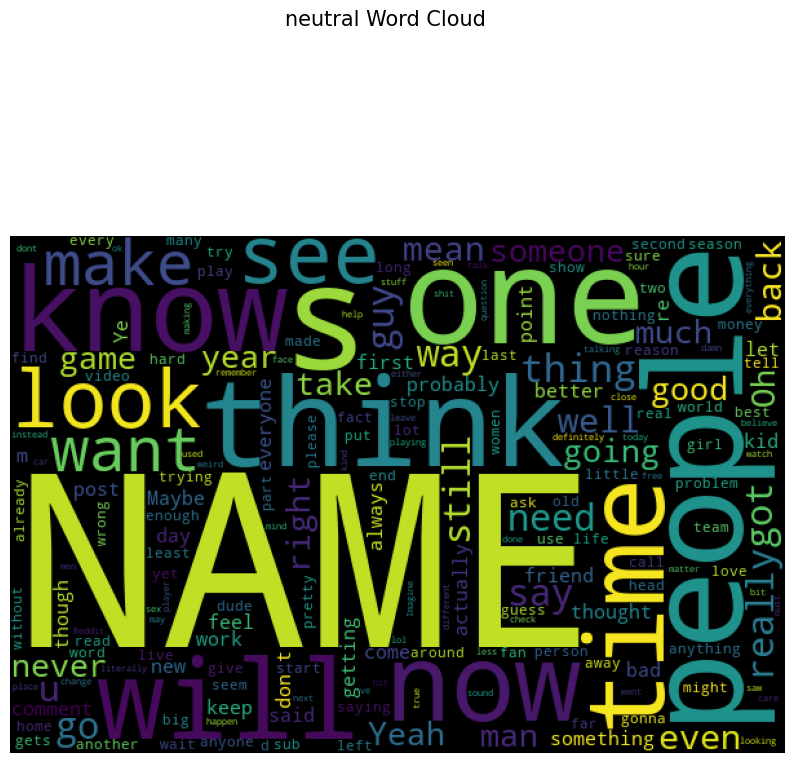

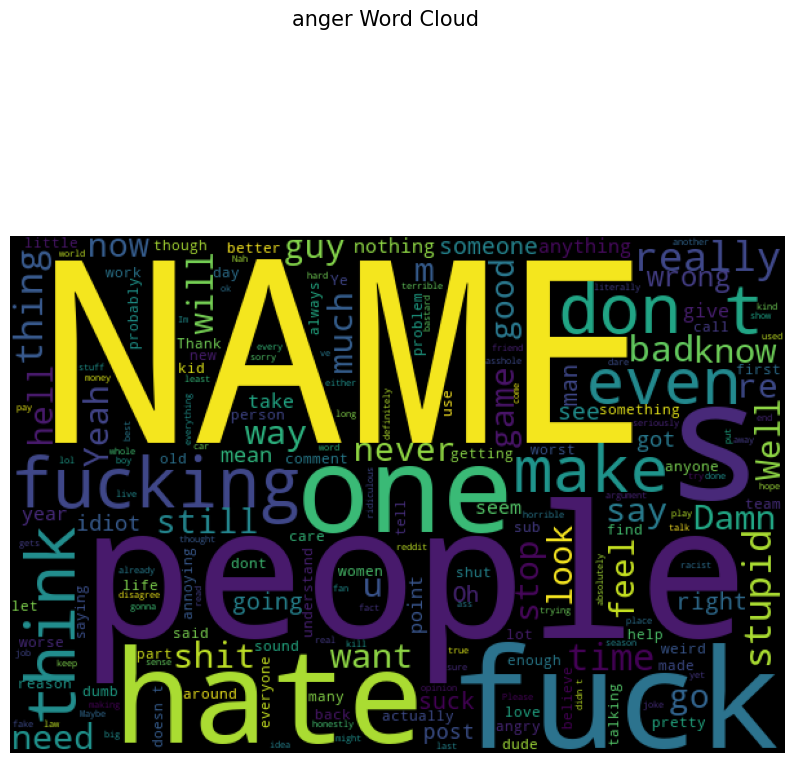

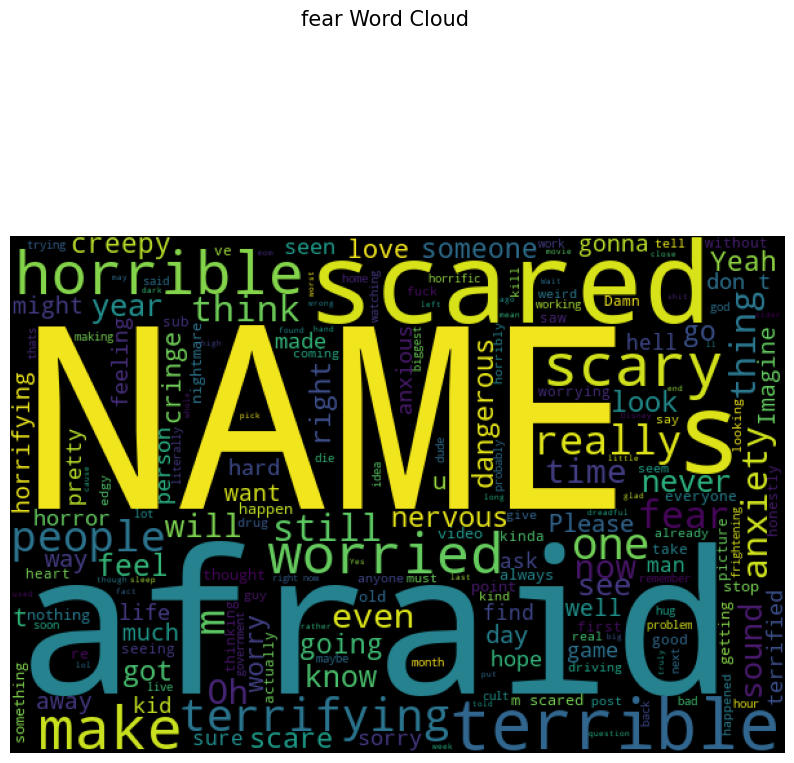

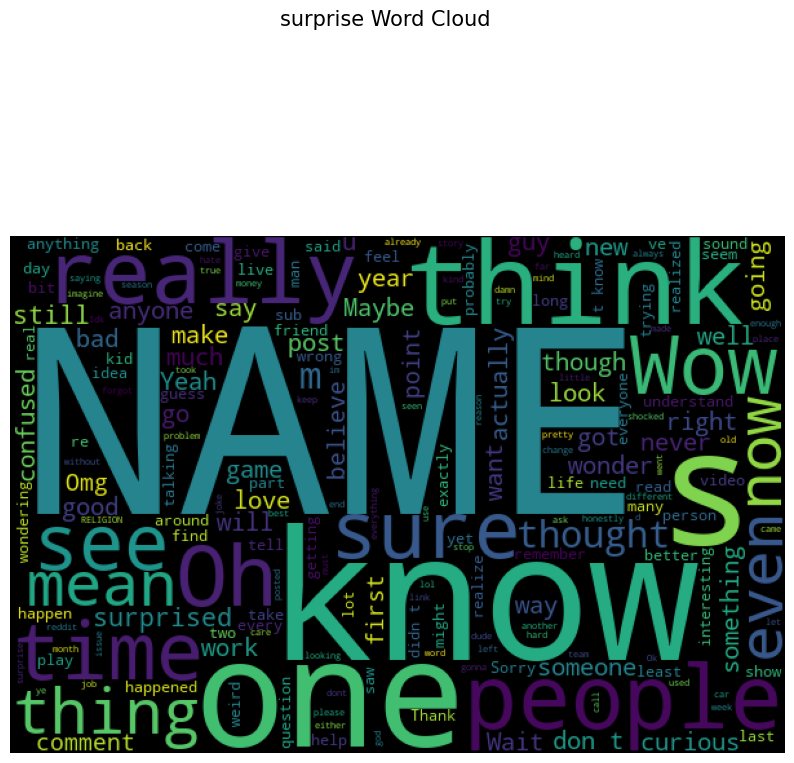

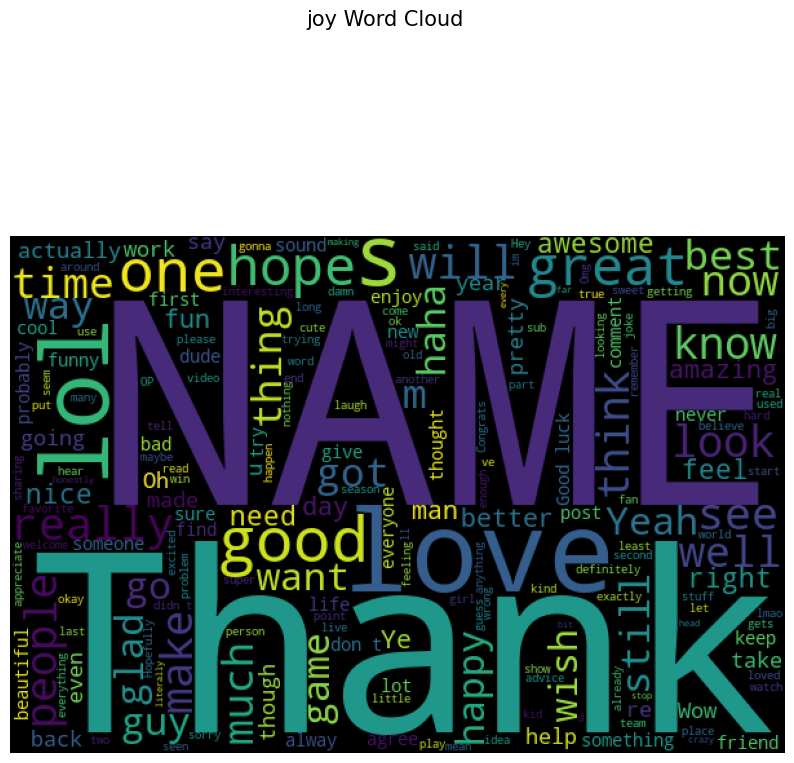

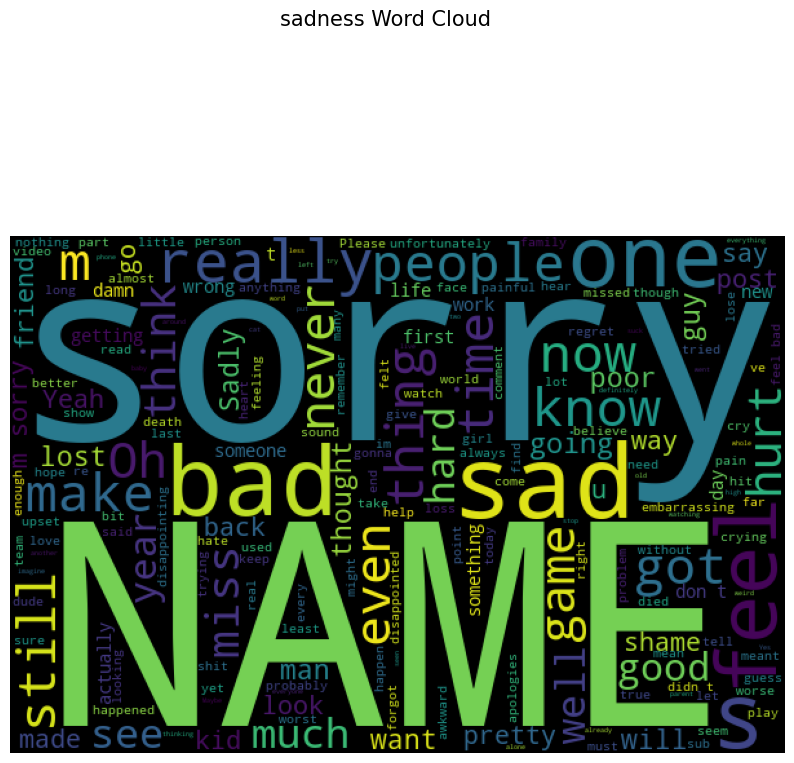

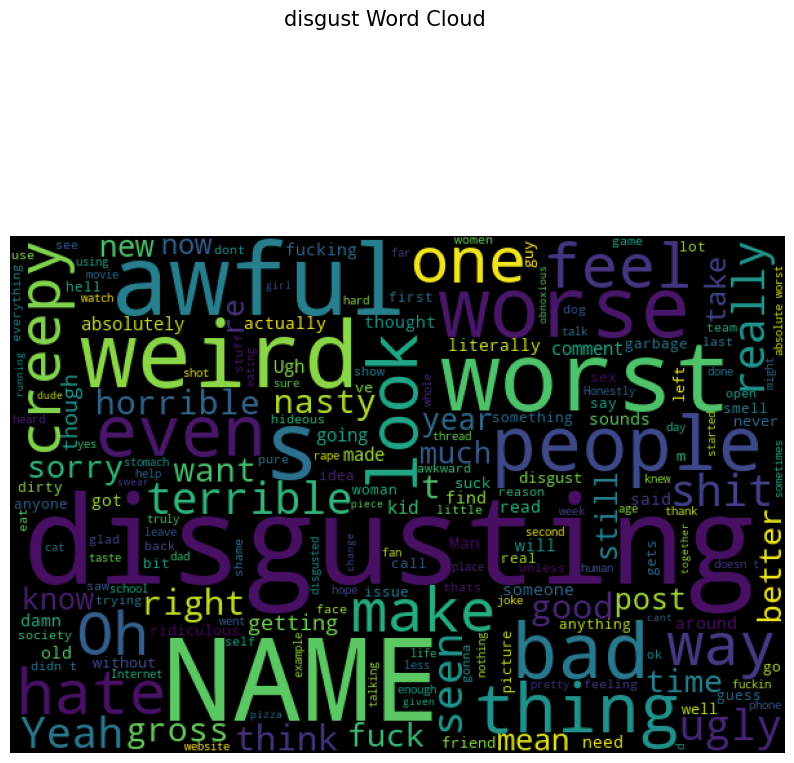

In [23]:
for emotion in emotion_list:
    text = " ".join([sentence for sentence in train_data.loc[train_data["Emotion"] == emotion, "text"]])
    wordcloud = WordCloud(width=600, height=400).generate(text)
    word_cloud(wordcloud, emotion)

In [24]:
train_data["Emotion"] = train_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
test_data["Emotion"] = test_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
dev_data["Emotion"] = dev_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})

C:\Users\Miry\AppData\Local\Temp\ipykernel_8056\2874847797.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data["Emotion"] = train_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
C:\Users\Miry\AppData\Local\Temp\ipykernel_8056\2874847797.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data["Emotion"] = test_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
C:\Users\Miry\AppData\Local\Temp\ipykernel_8

### Data cleaning

creating a class called DataInfo that when we Instantiate it will ,perform basic functions like getting the shape of the Dataframe ,get the Data types ,check for missing values and that will remove the Duplicates

In [25]:
class DataInfo:
    
    # Initialize with a DataFrame
    def __init__(self, df):
        self.df = df
        
    # Return the shape of the DataFrame
    def get_shape(self):
        shape = self.df.shape
        print(f"Shape of the DataFrame: {shape}")
        return shape
    
    # Return the data types of each column
    def get_dtypes(self):
        dtypes = self.df.dtypes
        print("Data types of each column:")
        print(dtypes)
        return dtypes
    
    # Return the number of missing values per column
    def get_missing_values(self):
        missing_values = self.df.isnull().sum()
        print("Missing values per feature:")
        print(missing_values)
        return missing_values
    
    # Print basic info including shape, data types, and missing values
    def get_basic_info(self):
        print("Basic Information:")
        self.get_shape()
        self.get_dtypes()
        self.get_missing_values()
        
    # Remove duplicate entries based on the 'post' column
    def remove_duplicates(self):
        initial_shape = self.df.shape
        self.df.drop_duplicates(subset='text', inplace=True)
        final_shape = self.df.shape
        print(f"Removed {initial_shape[0] - final_shape[0]} duplicate rows.")
        print(f"New shape of the DataFrame: {final_shape}")
        return self.df

In [26]:
# Instantiating our class
train_info = DataInfo(train_data)
test_info = DataInfo(test_data)
dev_info = DataInfo(dev_data)

# Get missing values for each DataFrame
train_info.get_missing_values()
test_info.get_missing_values()
dev_info.get_missing_values()

Missing values per feature:
text       0
id         0
Emotion    0
dtype: int64
Missing values per feature:
text       0
id         0
Emotion    0
dtype: int64
Missing values per feature:
text       0
id         0
Emotion    0
dtype: int64


text       0
id         0
Emotion    0
dtype: int64

It looks like there are no Missing values in our Dataset

In [27]:
# Get Duplicates values for each DataFrame
train_info.remove_duplicates()
test_info.remove_duplicates()
dev_info.remove_duplicates()

Removed 183 duplicate rows.
New shape of the DataFrame: (43227, 3)
Removed 6 duplicate rows.
New shape of the DataFrame: (5421, 3)
Removed 3 duplicate rows.
New shape of the DataFrame: (5423, 3)


,text,id,Emotion
0,Is this in New Orleans?? I really feel like th...,edgurhb,6
1,"You know the answer man, you are programmed to...",ee84bjg,3
2,I've never been this sad in my life!,edcu99z,4
3,The economy is heavily controlled and subsidiz...,edc32e2,3
4,He could have easily taken a real camera from ...,eepig6r,3
...,...,...,...
5421,It's pretty dangerous when the state decides w...,edyrazk,2
5422,I filed for divorce this morning. Hoping he mo...,edi2z3y,3
5423,"The last time it happened I just said, ""No"" an...",eewbqtx,0
5424,I can’t stand this arrogant prick he’s no bett...,eefx57m,0


We can now proceed to the next stage where we are going to remove any emojis present in our dataset, remove punctuation, lowercase all the posts, remove any noise such as mentions and hashtags, filter-out non-english words, lemmitize and then tokenize our data

In [28]:
def remove_pattern(text, pattern_regex):
    """Remove patterns from the text using regex."""
    if isinstance(text, str):
        return re.sub(pattern_regex, '', text)
    else:
        return text

def clean_posts(dataframes, column_name='text', pattern_regex=r"@[\w]*"):
    """Clean specified column in multiple DataFrames by removing patterns."""
    for df in dataframes:
        if column_name in df.columns:
            df[column_name] = df[column_name].apply(lambda x: remove_pattern(x, pattern_regex))
        else:
            print(f"Column '{column_name}' not found in DataFrame.")

# Call the clean_posts function
clean_posts([train_data, test_data, dev_data])

# Display the cleaned DataFrames
print("Cleaned DataFrame 1:")
print(train_data.head(10))
print("\nCleaned DataFrame 2:")
print(test_data.head(10))
print("\nCleaned DataFrame 3:")
print(dev_data.head(10))

Cleaned DataFrame 1:
                                                text       id  Emotion
0  My favourite food is anything I didn't have to...  eebbqej        6
1  Now if he does off himself, everyone will thin...  ed00q6i        6
2                     WHY THE FUCK IS BAYLESS ISOING  eezlygj        0
3                        To make her feel threatened  ed7ypvh        2
4                             Dirty Southern Wankers  ed0bdzj        0
5  OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...  edvnz26        5
6  Yes I heard abt the f bombs! That has to be wh...  ee3b6wu        3
7  We need more boards and to create a bit more s...  ef4qmod        3
8  Damn youtube and outrage drama is super lucrat...  ed8wbdn        3
9  It might be linked to the trust factor of your...  eczgv1o        6

Cleaned DataFrame 2:
                                                text       id  Emotion
0  I’m really sorry about your situation :( Altho...  eecwqtt        4
1    It's wonderful because it's a

####  Code below takes a DataFrame and a specified text column, and applies several steps to clean the text. These steps include removing patterns like mentions and hashtags, converting text to lowercase, handling emojis by replacing them with descriptive text, and removing punctuation, numbers, and common stopwords (like "the" or "and"). It provides a method to clean individual pieces of text as well as an entire column of text within the DataFrame, standardizing the data for further analysis or processing. This class simplifies the task of preparing text for tasks like machine learning or text analysis by making it cleaner and more uniform.

In [29]:
#Making a class Named text cleaner 
class TextCleaner:
    def __init__(self, df, text_column):
        self.df = df
        self.text_column = text_column
        self.stop_words = set(stopwords.words('english'))
    
    def remove_pattern(self, text, pattern_regex):
        #Remove a specific pattern from the text
        return re.sub(pattern_regex, '', text)

    def handle_emojis(self, text):
        #Replace emojis with corresponding text descriptions.
        return emoji.demojize(text, delimiters=(" ", " "))
    
    def to_lowercase(self, text):
        #Convert text to lowercase.
        return text.lower()
    
    def remove_punctuation_numbers(self, text):
        #Remove punctuation and numbers from the text.
        return re.sub(r'[^a-zA-Z\s]', '', text)
    
    def remove_mentions_hashtags(self, text):
        #Remove mentions (@) and hashtags (#) along with any attached words.
        text = self.remove_pattern(text, r'@\w+')
        text = self.remove_pattern(text, r'#\w+')
        return text
    
    def remove_stopwords(self, text):
        #Remove stopwords from the text
        return ' '.join(word for word in text.split() if word not in self.stop_words)
    
    def clean_single_text(self, text):
        #Clean a single piece of text by applying all steps.
        if pd.isna(text):
            return ''
        text = self.handle_emojis(text)
        text = self.to_lowercase(text)
        text = self.remove_punctuation_numbers(text)
        text = self.remove_mentions_hashtags(text)
        text = self.remove_stopwords(text)
        return text
    
    def clean_text(self):
        #Apply all cleaning steps to the specified text column in the DataFrame.
        self.df[self.text_column] = self.df[self.text_column].apply(lambda text: self.clean_single_text(text))
        return self.df

In [30]:
# Instantiate our TextCleaner Class
train_cleaned = TextCleaner(train_data, text_column='text')
test_cleaned = TextCleaner(test_data, text_column='text')
dev_cleaned = TextCleaner(dev_data, text_column='text')

train_data= train_cleaned.clean_text()
test_data= test_cleaned.clean_text()
dev_data= dev_cleaned.clean_text()

print(train_data.head())
print(test_data.head())
print(dev_data.head())

                                                text       id  Emotion
0                 favourite food anything didnt cook  eebbqej        6
1  everyone think hes laugh screwing people inste...  ed00q6i        6
2                                fuck bayless isoing  eezlygj        0
3                               make feel threatened  ed7ypvh        2
4                             dirty southern wankers  ed0bdzj        0
                                                text       id  Emotion
0  im really sorry situation although love names ...  eecwqtt        4
1                                    wonderful awful  ed5f85d        3
2    kings fan good luck guys interesting game watch  een27c3        3
3          didnt know thank teaching something today  eelgwd1        3
4  got bored haunting earth thousands years ultim...  eem5uti        6
                                                text       id  Emotion
0           new orleans really feel like new orleans  edgurhb        6
1  kno

## Exploratory Data Analysis(EDA)

<Axes: xlabel='Emotion', ylabel='count'>

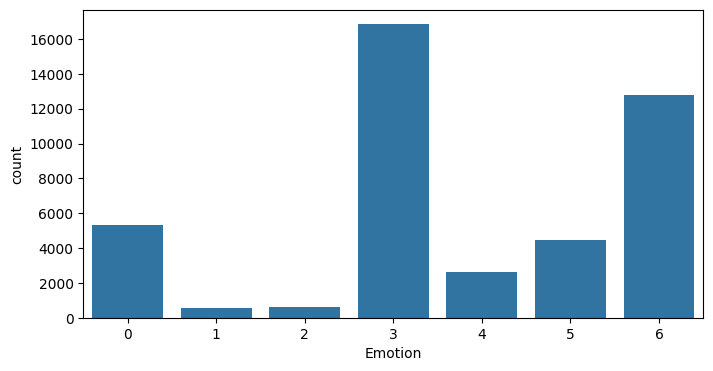

In [31]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion", data=train_data)

<Axes: xlabel='Emotion', ylabel='count'>

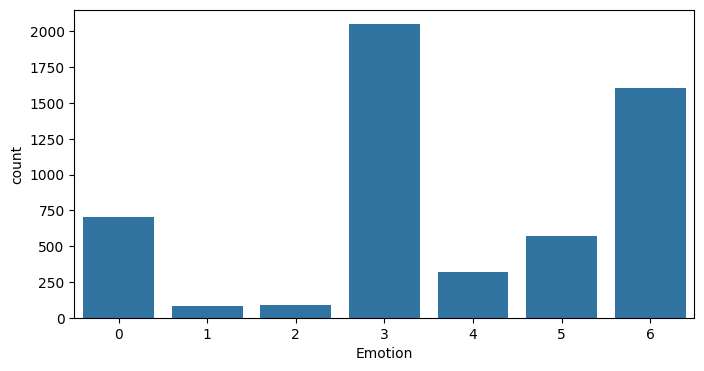

In [32]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion", data=test_data)

<Axes: xlabel='Emotion', ylabel='count'>

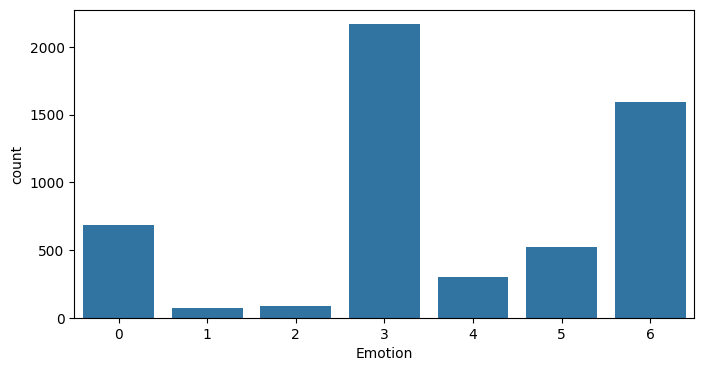

In [33]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion", data=dev_data)

## Modelling and Evaluation
In this section we perform modelling based on the outputs of the text preprocessing to determine which model is suitable for proper categorization that will be used for the Dataset

In [34]:
X_train = train_data["text"]
X_test = test_data["text"]
X_dev=  dev_data["text"]

y_train =  train_data["Emotion"]
y_test =  test_data["Emotion"]
y_dev =  dev_data["Emotion"]


In [35]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [36]:
from nltk.tokenize import word_tokenize
X_train_tokens = [word_tokenize(text) for text in X_train]

In [51]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### This code below prepares text data for a machine learning model by converting it into a numerical format and standardizing its length. First, it defines key parameters such as the vocabulary size (top 10,000 most common words), the maximum sequence length (50 words), and the number of output classes (7 for classification). Then, it uses a tokenizer to convert the words in the training, development, and test datasets into sequences of numbers, where each word is represented by a unique number based on its frequency. Since the sequences may have different lengths, padding is applied to ensure that all sequences are of equal length (50 words). This process makes the data uniform and ready for the model to process efficiently.

In [38]:

vocab_size = 10000  # Size of the vocabulary
max_len = 50       # Maximum length of input sequences
num_classes = 7    # Number of classes for classification
embedding_dim = 300 

#Tokenization and padding
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_dev_seq = tokenizer.texts_to_sequences(X_dev)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_dev_pad = pad_sequences(X_dev_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)



In [39]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_dev_tfidf = vectorizer.transform(X_dev)

In [40]:
# Example of trimming y_test to match X_test_tfidf
y_test = y_test[:X_test_tfidf.shape[0]]  # Trim y_test to have 5421 samples

In [41]:
smote = SMOTE(sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train_tfidf, y_train)

smote = SMOTE(sampling_strategy='minority')
X_test, y_test = smote.fit_resample(X_test_tfidf, y_test)

smote = SMOTE(sampling_strategy='minority')
X_dev, y_val = smote.fit_resample(X_dev_tfidf, y_dev)

## Naive Bayes.
Because of its suitability in text data and its simplicity we run it as the base classifier

In [42]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Step 2: Initialize the Naive Bayes model
nb_model = MultinomialNB()

# Step 3: Fit the model to the resampled training data
nb_model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred_train = nb_model.predict(X_train)
y_pred_test = nb_model.predict(X_test)

# Step 5: Evaluate the model
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Naive Bayes Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Naive Bayes Test Accuracy: {test_accuracy * 100:.2f}%")

print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

Naive Bayes Training Accuracy: 66.70%
Naive Bayes Test Accuracy: 53.48%
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.64      0.09      0.15       703
           1       0.67      0.66      0.66      2049
           2       0.00      0.00      0.00        90
           3       0.52      0.83      0.64      2049
           4       0.83      0.03      0.06       317
           5       0.76      0.05      0.10       573
           6       0.41      0.50      0.45      1605

    accuracy                           0.53      7386
   macro avg       0.55      0.31      0.30      7386
weighted avg       0.57      0.53      0.48      7386



c:\Users\Miry\Documents\data-science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Miry\Documents\data-science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Miry\Documents\data-science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

* Test accuracy in the Naive Bayes model significantly decreases as compared to training accuracy, which may indicate overfitting.
* The model performs better with more frequent classes (like Neutral and Joy) and struggles with classes with fewer instances (like Disgust, Anger, and Surprise).
* The findings show that although the model may accurately predict some classes in some cases, overall it is not very robust, especially when it comes to imbalanced classes.

To improve performance on underrepresented we considered using more complex models

* Precision:
A greater precision means that the positive class predictions contain fewer irrelevant cases.
An illustration of Class 1 (likely neutral):
Precision: 0.66, implying that 66% of the cases predicted as Class 1 were indeed Class 1.
* Recall:
A higher recall shows that the model catches more true instances of the positive class.
Example for Class 3 (maybe happiness):
Recall: 0.83 indicates that 83% of real Class 3 occurrences were recognized correctly.


## Support Vector Machine Classification

In [43]:
''' 
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create SVC model
svc_model = SVC(kernel='linear', probability=True)  

# Fit the model on the training data
svc_model.fit(X_train, y_train)

# Make predictions
y_pred_train = svc_model.predict(X_train)
y_pred_test = svc_model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"SVC Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"SVC Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification Report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

'''


' \nfrom sklearn.svm import SVC\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.preprocessing import StandardScaler\n\n# Create SVC model\nsvc_model = SVC(kernel=\'linear\', probability=True)  \n\n# Fit the model on the training data\nsvc_model.fit(X_train, y_train)\n\n# Make predictions\ny_pred_train = svc_model.predict(X_train)\ny_pred_test = svc_model.predict(X_test)\n\n# Calculate accuracy\ntrain_accuracy = accuracy_score(y_train, y_pred_train)\ntest_accuracy = accuracy_score(y_test, y_pred_test)\n\nprint(f"SVC Training Accuracy: {train_accuracy * 100:.2f}%")\nprint(f"SVC Test Accuracy: {test_accuracy * 100:.2f}%")\n\n# Classification Report\nprint("Classification Report (Test Set):")\nprint(classification_report(y_test, y_pred_test))\n\n'

## LSTM

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [45]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=300, input_length=50))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(50, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


c:\Users\Miry\Documents\data-science\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [46]:


# Trim X_dev to match the size of y_dev
X_dev = X_dev[:len(y_dev)]

# Optional: Print sizes to confirm
print("Size of X_dev (trimmed):", X_dev.shape[0])
print("Size of y_dev:", len(y_dev))

Size of X_dev (trimmed): 5423
Size of y_dev: 5423


In [47]:
# Perform one-hot encoding
num_classes = 7
model = Sequential()
model.add(Dense(num_classes, activation='softmax')) 
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_dev_one_hot = to_categorical(y_dev, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)



In [48]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Training the model using one-hot encoded labels
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Training the model
model.fit(X_train, y_train_one_hot,epochs=5, batch_size=100, validation_data=(X_dev, y_dev_one_hot), callbacks=[early_stopping])
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
# Make predictions
y_pred_proba = model.predict(X_test)
# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_proba, axis=1)
# Assuming y_test is in categorical format, convert it to class labels
y_test_labels = np.argmax(y_test_one_hot, axis=1)
# Evaluate performance
print("Neural Network Testing Accuracy Score:", accuracy_score(y_test_labels, y_pred_labels))
print(f"Neural Network Training Accuracy Score : {accuracy}") 
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))      

Epoch 1/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4851 - loss: 1.8112 - val_accuracy: 0.3994 - val_loss: 1.6524
Epoch 2/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5594 - loss: 1.5063 - val_accuracy: 0.4379 - val_loss: 1.5586
Epoch 3/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5994 - loss: 1.3670 - val_accuracy: 0.4695 - val_loss: 1.4946
Epoch 4/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6262 - loss: 1.2629 - val_accuracy: 0.4879 - val_loss: 1.4391
Epoch 5/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6428 - loss: 1.1910 - val_accuracy: 0.4959 - val_loss: 1.3967
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5028 - loss: 1.3962
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Neural Network Testing Accuracy Score: 0.5675602491199567
Neural Network Training Accuracy Score : 0.5675602555274963
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.04      0.08       70

c:\Users\Miry\Documents\data-science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Miry\Documents\data-science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Miry\Documents\data-science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

## CNN

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, kernel_sizes=[3, 4, 5], num_filters=100):
        super(EmotionCNN, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Convolutional layers with different kernel sizes
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embedding_dim))
            for k in kernel_sizes
        ])
        
        # Fully connected layer
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, seq_length, embedding_dim]
        x = x.unsqueeze(1)  # [batch_size, 1, seq_length, embedding_dim]

        # Apply convolution and max-pooling
        conv_results = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(result, result.size(2)).squeeze(2) for result in conv_results]

        # Concatenate pooled features and apply dropout
        out = torch.cat(pooled, 1)
        out = self.dropout(out)

        # Fully connected layer
        out = self.fc(out)

        return out

# Hyperparameters
vocab_size =  max(X_train_pad.max(), X_test_pad.max()) + 1 # Adjust this according to your data
embedding_dim = 50  # Use pre-trained embeddings if possible
num_classes = len(set(y_train))  # Based on your emotion labels
kernel_sizes = [3, 4, 5]
num_filters = 100

# Instantiate the CNN model
model = EmotionCNN(vocab_size, embedding_dim, num_classes, kernel_sizes, num_filters)

# Define the optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [51]:
#TRUNCATING imbalanced data
min_len = min(len(X_train_pad), len(y_train))
X_train_pad = X_train_pad[:min_len]
y_train = y_train[:min_len]


In [52]:
#TRUNCATING imbalanced data
min_len = min(len(X_test_pad), len(y_test))
X_test_pad = X_test_pad[:min_len]
y_test = y_test[:min_len]

In [53]:
from torch.utils.data import DataLoader, TensorDataset

# Convert to TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train_pad), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test_pad), torch.tensor(y_test))

# Create DataLoader for batching
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [54]:
model = EmotionCNN(vocab_size, embedding_dim, num_classes, kernel_sizes, num_filters)

In [57]:
# Set the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the appropriate device
model.to(device)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 12

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        # Move inputs and labels to device (GPU/CPU)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    # Print training statistics after each epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_predictions / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

print('Training Complete')

Epoch 1/12, Loss: 0.6983, Accuracy: 0.7483
Epoch 2/12, Loss: 0.6633, Accuracy: 0.7624
Epoch 3/12, Loss: 0.6313, Accuracy: 0.7742
Epoch 4/12, Loss: 0.6028, Accuracy: 0.7832
Epoch 5/12, Loss: 0.5728, Accuracy: 0.7954
Epoch 6/12, Loss: 0.5553, Accuracy: 0.8011
Epoch 7/12, Loss: 0.5257, Accuracy: 0.8139
Epoch 8/12, Loss: 0.5097, Accuracy: 0.8188
Epoch 9/12, Loss: 0.4836, Accuracy: 0.8276
Epoch 10/12, Loss: 0.4712, Accuracy: 0.8308
Epoch 11/12, Loss: 0.4505, Accuracy: 0.8408
Epoch 12/12, Loss: 0.4411, Accuracy: 0.8449
Training Complete


### Analysis:
* Loss Decrease:
 The loss consistently decreases over the epochs, which indicates that the model is learning. A decreasing loss means the model is improving its predictions on the training data.

* Accuracy Improvement: 
The accuracy improves with each epoch as well. Starting at about 74.83% and ending at 84.49 % indicates that the model is becoming more accurate in its predictions.

Evaluating the model using the Test Data

In [56]:
# Set the model to evaluation mode
model.eval()  
test_loss = 0.0
correct_predictions = 0
total_samples = 0

# Disable gradient calculation for evaluation
with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Accumulate loss
        test_loss += loss.item() * inputs.size(0)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

# Print test accuracy
test_loss = test_loss / len(test_loader.dataset)
test_acc = correct_predictions / total_samples
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 1.2922, Test Accuracy: 0.5868


Test Loss:

The test loss of 2.2731 is higher than the final training loss of 0.4032 . This discrepancy can indicate that the model is overfitting to the training data, meaning it has learned patterns that do not generalize well to new, unseen data.


Test Accuracy:

The test accuracy of 56.21% is lower than the final training accuracy of 85.76%. This further reinforces the observation of overfitting, as the model performs better on the training dataset than on the test dataset.

## Recommendations


* Align with Business Objectives: <br>
   Make sure the precision satisfies the requirements of the company. Establish appropriate cutoff points depending on the particular use case, such as fraud detection or product suggestions.

* Concentrate on accuracy or Recall:<br>
 Depending on the business environment, maximise recall (to minimise damaging false negatives) or accuracy (to decrease expensive false positives).

* Test on Real-World Data:<br>
 Conduct A/B testing to determine how the model affects actual business performance and validate the model using current business data.
 Weigh the trade-offs between increasing accuracy and the expense of more computer power or complexity using a cost-benefit analysis.

* Model Explainability:<br>
Especially in regulated sectors, make CNN outputs interpretable by using tools like Grad-CAM or LIME.

* Update and Monitor:<br>
 After deployment, periodically assess the model's performance and retrain it to adapt to evolving business needs.
 the Model which can be used make a chatbot Assistant

*Constant Maintenance
  



### Conclusion

We Decided to use CNN , In a business scenario, the objective is to guarantee that the CNN contributes quantifiable benefit to company outcomes in addition to attaining high accuracy. Prioritise guaranteeing scalability, cost-effectiveness, explainability for stakeholders, and matching model performance to business objectives. You can optimise the model's effect on the company by keeping an eye on it and making improvements all the time.